-------------
# １．ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.linear_model import Lasso

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

import time

--------
# ２．実験設定

## 2.1 実験設定

In [2]:
### 実験データの設定 ###
n = 100000  # データサイズ
p = 20  # 特徴量数
s = 5  # 非ゼロ係数の数
rho = 0.35  # 相関レベル
snr = 1  # 信号対雑音比
beta_type = "type1"


### 実験設定 ###
SAMPLE_SIZE = 100  # 標本サイズ
N_TRIALS = 10000  # 試行回数（標本抽出を行う回数）
m_VALUE = 2  # 最適標本配分における各クラスタの最小標本数
RANDOM_STATE = 0  # 乱数シード

### 実験方法 ###
# クラスタリング
CLUSTERING_METHOD_LIST = ["kmeans"]  # ["gmm", "kmeans", "xmeans"]
N_CLUSTERS = 6  # クラスタ数（Kmeans と GMM）
K_MIN = 2  # 最小クラスタ数（Xmeans)
K_MAX = 10  # 最大クラスタ数(Xmeans)

# 特徴量選択
CRITERION_LIST = [
    "none",
    "lasso",  # "lasso" を選択した場合はalphaも調節する
    "F",
    "T",
]
LASSO_ALPHA = 0.035  # 選ばれる特徴量の数を確認して調節
SELECT_MAXIMUM_FEATURES = "yes"  # "yes" or "no"（特徴量数が MAXIMUM_FEATURES_TO_SELECT になるまで選ぶかいなか）
MAXIMUM_FEATURES_TO_SELECT = s  # 選択される最大の特徴量(特徴量選択ありの場合)


# 標本配分
ALLOCATION_LIST = [
    "Proportional",
    "Post",
    "Optimal",
]


### 可視化 ###
TITLE_SIZE = 20
LABEL_SIZE = 15
TICK_SIZE = 12.5

### シード ###
np.random.seed(42)

In [3]:
if beta_type == "type1":
    BETA = np.array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
if beta_type == "type2":
    BETA = np.array([10, 0, 0, 0, 8, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0])
ALL_FEATURES_INDEX = [i for i in range(p)]


## 2.2 各手法の名前

In [4]:
stratification_methods = list(itertools.product(CRITERION_LIST, CLUSTERING_METHOD_LIST))
METHODS_NAME_DICT = {}
for method in stratification_methods:
    if method == ("none", "kmeans"):
        METHODS_NAME_DICT[method] = "Kmeans"
    if method == ("none", "xmeans"):
        METHODS_NAME_DICT[method] = "Xmeans"
    if method == ("none", "gmm"):
        METHODS_NAME_DICT[method] = "GMM"

    if method == ("F", "kmeans"):
        METHODS_NAME_DICT[method] = "SFS-Kmeans-F"
    if method == ("F", "xmeans"):
        METHODS_NAME_DICT[method] = "SFS-Xmeans-F"
    if method == ("F", "gmm"):
        METHODS_NAME_DICT[method] = "SFS-GMM-Loglikelyhood"

    if method == ("lasso", "kmeans"):
        METHODS_NAME_DICT[method] = "Lasso-Kmeans"
    if method == ("lasso", "xmeans"):
        METHODS_NAME_DICT[method] = "Lasso-Xmeans"
    if method == ("lasso", "gmm"):
        METHODS_NAME_DICT[method] = "Lasso-GMM"

    if method == ("T", "kmeans"):
        METHODS_NAME_DICT[method] = "SFS-Kmeans-T"
    if method == ("T", "xmeans"):
        METHODS_NAME_DICT[method] = "SFS-Xmeans-T"

print("METHODS_NAME_DICT", METHODS_NAME_DICT)


METHODS_NAME_DICT {('none', 'kmeans'): 'Kmeans', ('lasso', 'kmeans'): 'Lasso-Kmeans', ('F', 'kmeans'): 'SFS-Kmeans-F', ('T', 'kmeans'): 'SFS-Kmeans-T'}


-----------
# ３．データの前処理

## 3.1 データ作成

In [5]:
def simulate_data(n, p, rho, snr, beta, seed):
    np.random.seed(seed)

    # 2. 共分散行列Σの生成
    Sigma = np.fromfunction(lambda i, j: rho ** np.abs(i - j), (p, p), dtype=int)

    # 3. Xの生成 (多変量正規分布)
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)

    # 4. 応答変数Yの生成
    signal_variance = beta.T @ Sigma @ beta  # β₀の分散
    noise_variance = signal_variance / snr  # ノイズ分散 σ²
    noise = np.random.normal(scale=np.sqrt(noise_variance), size=n)  # ノイズ項
    Y = X @ beta + noise

    return X, Y, beta


In [6]:
X_train, y_train, beta_train = simulate_data(
    n=n, p=p, rho=rho, snr=snr, beta=BETA, seed=0
)
X_test, y_test, beta_test = simulate_data(n=n, p=p, rho=rho, snr=snr, beta=BETA, seed=1)


## 3.5 標準化

In [7]:
sc = StandardScaler()
# 訓練データに基づいてfit
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

-------------
# 4. 特徴量選択

In [8]:
TIME_DICT = {}
SELECTED_FEATURES_DICT = {}

## 4.1 特徴量選択なしの場合

In [9]:
for method, name in METHODS_NAME_DICT.items():
    if method[0] == "none":
        SELECTED_FEATURES_DICT[name] = np.array(ALL_FEATURES_INDEX)
        TIME_DICT[name] = 0


## 4.2 Lasso で特徴量選択する場合

In [10]:
def lasso(X: NDArray, y: NDArray, alpha: float) -> list:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    features_list = np.where(lasso.coef_ != 0)[0]
    return features_list

In [11]:
if "lasso" in CRITERION_LIST:
    start_time = time.time()
    selected_features_index = lasso(X_train_std, y_train, alpha=LASSO_ALPHA)
    end_time = time.time()

    for method, name in METHODS_NAME_DICT.items():
        if method[0] == "lasso":
            SELECTED_FEATURES_DICT[name] = selected_features_index
            TIME_DICT[name] = end_time - start_time

    print(selected_features_index)

[ 0  4  8 12 16]


## 4.3 Wrapper法 で特徴量選択する場合

### 準備

In [12]:
class Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        maximum_features_to_select: int,
        n_clusters: int,
        criterion: str,
        clustering_method: str,
        random_state: int = 0,
        select_maximum_features: str = "yes",
        k_min: int = 2,
        k_max: int = 10,
    ):
        self.maximum_features_to_select = maximum_features_to_select
        self.n_clusters = n_clusters
        self.criterion = criterion
        self.clustering_method = clustering_method
        self.random_state = random_state
        self.select_maximum_features = select_maximum_features
        self.k_min = k_min
        self.k_max = k_max

    def fss(self, X: NDArray, y: NDArray) -> "Wrapper":
        X, y = check_X_y(X, y)
        n_all_features = X.shape[1]  # 総特徴量数

        ##### 初期化 #####
        features_score_dict = {}  # スコアの推移の確認用
        current_features = []  # 選択された特徴量
        remaining_features = list(range(n_all_features))  # 選択されていない特徴量

        if self.select_maximum_features == "no":
            best_score = -np.inf  # 初期スコア（特徴量を最大数選ぶとは限らないとき）

        ##### 特徴量選択とクラスタリング #####
        while len(current_features) < self.maximum_features_to_select:
            best_feature = None
            if self.select_maximum_features == "yes":
                best_score = -np.inf  # 初期スコア（特徴量を最大数選ぶとき）

            for feature in remaining_features:
                temp_features = current_features + [
                    feature
                ]  # スコアを調べたい特徴量サブセット

                score, labels = self.crit(X[:, temp_features], y)
                if score > best_score:
                    best_score = score
                    best_feature = feature
                    best_labels = np.array(labels)
                    best_cluster_size = np.bincount(best_labels)
                    best_n_clusters = len(np.unique(best_labels))

            # 選択された特徴量をcurrent_featuresに追加し、remaining_features から除外
            if best_feature is not None:
                current_features.append(best_feature)
                remaining_features.remove(best_feature)
                num_of_features = len(current_features)
                print(
                    "num_of_features:",
                    num_of_features,
                    "current_features:",
                    current_features,
                    ", score:",
                    best_score,
                    "best_n_clusters:",
                    best_n_clusters,
                    "best_cluster_size",
                    best_cluster_size,
                )
                features_score_dict[str(num_of_features)] = best_score  # スコア確認用

            else:
                break

        ##### 最終的な特徴量とクラスタリング結果 #####
        self.selected_features_index = current_features
        self.features_score_dict = features_score_dict

        return self

    def crit(self, X: NDArray, y: NDArray) -> tuple[float, list, int]:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            model = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
        if self.clustering_method == "kmeans":
            model = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
        if self.clustering_method == "xmeans":
            model = self.xmeans(X)

        model.fit(X)
        labels = model.predict(X)

        if self.criterion == "F":
            score = model.score(X)
        elif self.criterion == "T" and (
            self.clustering_method == "kmeans" or self.clustering_method == "xmeans"
        ):
            tss = 0
            for k in np.unique(labels):
                y_k = y[labels == k]
                mean_y_k = np.mean(y_k)
                tss += np.sum((y_k - mean_y_k) ** 2)
            score = -tss

        return score, labels

    def compute_bic(self, X: NDArray, kmeans: KMeans) -> float:
        # クラスタリング結果の取得
        labels = kmeans.labels_
        clusters = kmeans.cluster_centers_
        n_clusters = len(clusters)
        n = len(X)
        m = X.shape[1]
        # クラスター内の分散の合計
        variance = np.sum(
            [
                np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
                for i in range(n_clusters)
            ]
        )
        # BIC の計算
        bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
        return bic

    def xmeans(self, X: NDArray) -> KMeans:
        kmeans = KMeans(
            n_clusters=self.k_min, random_state=self.random_state
        )  # 初期クラスター数で KMeans を実行
        kmeans.fit(X)
        best_bic = self.compute_bic(X, kmeans)
        best_kmeans = kmeans
        for k in range(self.k_min + 1, self.k_max + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(X)
            # BIC を計算
            current_bic = self.compute_bic(X, kmeans)
            # BIC が改善される場合、クラスタ数を更新
            if current_bic < best_bic:
                best_bic = current_bic
                best_kmeans = kmeans
        # 最適なクラスタリング結果を返す
        return best_kmeans

    def get_selected_features_index(self) -> list:
        return self.selected_features_index  # 最終的に選択された特徴量のインデックス

    def get_features_score_dict(self) -> dict:
        return self.features_score_dict  # スコアの推移（確認用）


In [13]:
def process_wrapper(
    instance: "Wrapper", X: NDArray, y: NDArray
) -> tuple[list, dict[int, float]]:
    instance.fss(X, y)
    selected_features_index = instance.get_selected_features_index()
    features_score_dict = instance.get_features_score_dict()
    selected_features_index = np.array(selected_features_index)

    return selected_features_index, features_score_dict

### インスタンスのリスト作成

In [14]:
instances = []
for method, name in METHODS_NAME_DICT.items():
    if method[0] == "F" or method[0] == "T":
        instances.append(
            (
                name,
                Wrapper(
                    maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
                    n_clusters=N_CLUSTERS,
                    criterion=method[0],
                    clustering_method=method[1],
                    random_state=RANDOM_STATE,
                    select_maximum_features=SELECT_MAXIMUM_FEATURES,
                    k_min=K_MIN,
                    k_max=K_MAX,
                ),
            )
        )
print(instances)


[('SFS-Kmeans-F', Wrapper(clustering_method='kmeans', criterion='F', maximum_features_to_select=5,
        n_clusters=6)), ('SFS-Kmeans-T', Wrapper(clustering_method='kmeans', criterion='T', maximum_features_to_select=5,
        n_clusters=6))]


### Wrapper 法実施

In [15]:
features_score_dict_dict = {}  # スコア推移確認用

# 各インスタンスに対して処理を実行
for method_name, instance in instances:
    print("[", method_name, "]")
    start_time = time.time()
    selected_features_index, features_score_dict = process_wrapper(
        instance, X_train_std, y_train
    )
    end_time = time.time()

    SELECTED_FEATURES_DICT[method_name] = selected_features_index
    TIME_DICT[method_name] = end_time - start_time

    features_score_dict_dict[method_name] = features_score_dict  # スコア推移確認用

[ SFS-Kmeans-F ]
num_of_features: 1 current_features: [5] , score: -5754.6625799082785 best_n_clusters: 6 best_cluster_size [24997  8756  6527 23508 19640 16572]
num_of_features: 2 current_features: [5, 4] , score: -47688.9157679629 best_n_clusters: 6 best_cluster_size [16720 17171 11312 21287 11254 22256]
num_of_features: 3 current_features: [5, 4, 3] , score: -112448.81690726348 best_n_clusters: 6 best_cluster_size [17740 14098 17427 17839 18531 14365]
num_of_features: 4 current_features: [5, 4, 3, 2] , score: -186611.5277324685 best_n_clusters: 6 best_cluster_size [13900 17775 17930 18799 13738 17858]
num_of_features: 5 current_features: [5, 4, 3, 2, 1] , score: -265632.06026563194 best_n_clusters: 6 best_cluster_size [18137 17413 14945 15277 17132 17096]
[ SFS-Kmeans-T ]
num_of_features: 1 current_features: [4] , score: -923091.1113764092 best_n_clusters: 6 best_cluster_size [ 6473 19750 16342  8659 25256 23520]
num_of_features: 2 current_features: [4, 12] , score: -865695.59289598

## 4.4 特徴量選択の結果

### Wrapper 法のスコア推移

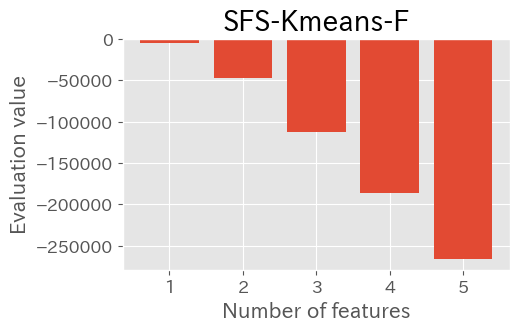

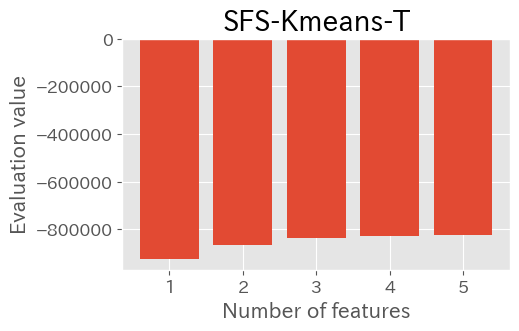

In [16]:
for method_name, instance in instances:
    # 棒グラフを作成
    plt.figure(figsize=(5, 3))
    plt.bar(
        features_score_dict_dict[method_name].keys(),
        features_score_dict_dict[method_name].values(),
    )
    plt.title(f"{method_name}", fontsize=TITLE_SIZE)
    plt.xlabel("Number of features", fontsize=LABEL_SIZE)
    plt.ylabel("Evaluation value", fontsize=LABEL_SIZE)
    # plt.ylim(,)
    plt.tick_params(axis="both", labelsize=TICK_SIZE)
    plt.show()

### 特徴量選択の結果

In [17]:
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    print("選択された特徴量：", SELECTED_FEATURES_DICT[method_name])
    print(f"特徴量選択にかかった時間：{round(TIME_DICT[method_name], 3)} s")
    print()

【Kmeans】
選択された特徴量： [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
特徴量選択にかかった時間：0 s

【Lasso-Kmeans】
選択された特徴量： [ 0  4  8 12 16]
特徴量選択にかかった時間：1.705 s

【SFS-Kmeans-F】
選択された特徴量： [5 4 3 2 1]
特徴量選択にかかった時間：7.238 s

【SFS-Kmeans-T】
選択された特徴量： [ 4 12  8  0 16]
特徴量選択にかかった時間：7.199 s



-----------
# 5. クラスタリングと標本配分

## 5.1 クラスタリング

### 準備

In [18]:
def compute_bic(X: NDArray, kmeans: KMeans) -> float:
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X: NDArray, k_min: int, k_max: int) -> KMeans:
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_kmeans = kmeans
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        if current_bic < best_bic:
            best_bic = current_bic
            best_kmeans = kmeans
    return best_kmeans

In [19]:
def clustering(
    X_train: NDArray,
    X_test: NDArray,
    methods_name_dict: dict,
    n_clusters: int,
    random_state: int,
    k_min: int,
    k_max: int,
    selected_features_dict: dict,
) -> tuple[dict, dict, dict, dict]:
    cluster_label_dict_train = {}
    cluster_size_dict_train = {}
    cluster_label_dict_test = {}
    cluster_size_dict_test = {}

    for method, name in methods_name_dict.items():
        if method[1] == "kmeans":
            model = KMeans(n_clusters=n_clusters, random_state=random_state)
        if method[1] == "gmm":
            model = GaussianMixture(
                n_components=n_clusters, random_state=random_state, init_params="kmeans"
            )
        if method[1] == "xmeans":
            model = xmeans(X_train, k_min=k_min, k_max=k_max)

        cluster_label_train = model.fit_predict(
            X_train[:, selected_features_dict[name]]
        )
        cluster_size_train = np.bincount(cluster_label_train)
        cluster_label_test = model.predict(X_test[:, selected_features_dict[name]])
        cluster_size_test = np.bincount(cluster_label_test, minlength=n_clusters)

        cluster_label_dict_train[name] = cluster_label_train
        cluster_size_dict_train[name] = cluster_size_train
        cluster_label_dict_test[name] = cluster_label_test
        cluster_size_dict_test[name] = cluster_size_test

    return (
        cluster_label_dict_train,
        cluster_size_dict_train,
        cluster_label_dict_test,
        cluster_size_dict_test,
    )


### クラスタリングの実施

In [20]:
# 訓練データ
(
    CLUSTER_LABEL_DICT_TRAIN,
    CLUSTER_SIZE_DICT_TRAIN,
    CLUSTER_LABEL_DICT_TEST,
    CLUSTER_SIZE_DICT_TEST,
) = clustering(
    X_train=X_train_std,
    X_test=X_test_std,
    methods_name_dict=METHODS_NAME_DICT,
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    k_min=K_MIN,
    k_max=K_MAX,
    selected_features_dict=SELECTED_FEATURES_DICT,
)

In [21]:
def cauculate_dict_for_allocation(
    cluster_size_dict_train: dict[str, NDArray],
    cluster_size_dict_test: dict[str, NDArray],
    min_n_h: int,
) -> tuple[dict[str, list[int]], dict[str, list[int]], dict[str, list[int]]]:
    cluster_size_dict_for_allocation_train = {}
    cluster_size_dict_for_allocation_test = {}
    unique_label_dict_for_allocation = {}

    for method_name, cluster_size in cluster_size_dict_train.items():
        cluster_size_train = []
        cluster_size_test = []
        labels = []
        for i in range(len(cluster_size)):
            if (
                cluster_size_dict_train[method_name][i] >= min_n_h
                and cluster_size_dict_test[method_name][i] >= min_n_h
            ):
                cluster_size_train.append(cluster_size_dict_train[method_name][i])
                cluster_size_test.append(cluster_size_dict_test[method_name][i])
                labels.append(i)
        cluster_size_dict_for_allocation_train[method_name] = cluster_size_train
        cluster_size_dict_for_allocation_test[method_name] = cluster_size_test
        unique_label_dict_for_allocation[method_name] = labels

    return (
        cluster_size_dict_for_allocation_train,
        cluster_size_dict_for_allocation_test,
        unique_label_dict_for_allocation,
    )


In [22]:
(
    CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN,
    CLUSTER_SIZE_DICT_FOR_ALLOCATION_TEST,
    UNIQUE_LABEL_DICT_FOR_ALLOCATION,
) = cauculate_dict_for_allocation(
    cluster_size_dict_train=CLUSTER_SIZE_DICT_TRAIN,
    cluster_size_dict_test=CLUSTER_SIZE_DICT_TEST,
    min_n_h=1,
)

(
    CLUSTER_SIZE_DICT_FOR_OPTIMAL_TRAIN,
    CLUSTER_SIZE_DICT_FOR_OPTIMAL_TEST,
    UNIQUE_LABEL_DICT_FOR_OPTIMAL,
) = cauculate_dict_for_allocation(
    cluster_size_dict_train=CLUSTER_SIZE_DICT_TRAIN,
    cluster_size_dict_test=CLUSTER_SIZE_DICT_TEST,
    min_n_h=2,
)


### クラスタリング結果

In [23]:
print("【訓練データ】")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{CLUSTER_SIZE_DICT_TRAIN[method_name]}")
    print(
        f"（クラスタサイズが１以上の層：{CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN[method_name]}"
    )
    print(
        f"（クラスタサイズが２以上の層（最適標本配分）：{CLUSTER_SIZE_DICT_FOR_OPTIMAL_TRAIN[method_name]}"
    )
print()

print("【テストデータ】")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{CLUSTER_SIZE_DICT_TEST[method_name]}")
    print(
        f"（クラスタサイズが１以上の層：{CLUSTER_SIZE_DICT_FOR_ALLOCATION_TEST[method_name]}"
    )
    print(
        f"（クラスタサイズが２以上の層（最適標本配分）：{CLUSTER_SIZE_DICT_FOR_OPTIMAL_TEST[method_name]}"
    )

print("クラスタラベル（比例配分、事後層化）")
print(UNIQUE_LABEL_DICT_FOR_ALLOCATION)
print("クラスタラベル（最適標本配分）")
print(UNIQUE_LABEL_DICT_FOR_OPTIMAL)


【訓練データ】
Kmeans:[17217 17238 16848 16007 16202 16488]
（クラスタサイズが１以上の層：[17217, 17238, 16848, 16007, 16202, 16488]
（クラスタサイズが２以上の層（最適標本配分）：[17217, 17238, 16848, 16007, 16202, 16488]
Lasso-Kmeans:[17094 16550 16673 16563 16455 16665]
（クラスタサイズが１以上の層：[17094, 16550, 16673, 16563, 16455, 16665]
（クラスタサイズが２以上の層（最適標本配分）：[17094, 16550, 16673, 16563, 16455, 16665]
SFS-Kmeans-F:[18137 17413 14945 15277 17132 17096]
（クラスタサイズが１以上の層：[18137, 17413, 14945, 15277, 17132, 17096]
（クラスタサイズが２以上の層（最適標本配分）：[18137, 17413, 14945, 15277, 17132, 17096]
SFS-Kmeans-T:[17094 16550 16673 16563 16455 16665]
（クラスタサイズが１以上の層：[17094, 16550, 16673, 16563, 16455, 16665]
（クラスタサイズが２以上の層（最適標本配分）：[17094, 16550, 16673, 16563, 16455, 16665]

【テストデータ】
Kmeans:[17157 17393 16790 15938 16292 16430]
（クラスタサイズが１以上の層：[17157, 17393, 16790, 15938, 16292, 16430]
（クラスタサイズが２以上の層（最適標本配分）：[17157, 17393, 16790, 15938, 16292, 16430]
Lasso-Kmeans:[17132 16606 16823 16486 16218 16735]
（クラスタサイズが１以上の層：[17132, 16606, 16823, 16486, 16218, 16735]
（クラスタサイズが２

## 5.2 標本配分

### 基底クラス

In [24]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self,
        sample_size: int,
        random_state: int,
        method_name: str,
        cluster_size_dict_for_allocation: dict,
    ):
        self.sample_size = sample_size
        self.random_state = random_state
        self.method_name = method_name
        self.N = np.array(cluster_size_dict_for_allocation[self.method_name])

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        raise NotImplementedError

### ① 比例配分（Proportional）

In [25]:
class Proportional(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.sample_size).astype(int)

        if n.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.sample_size

        if n.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタに足す
            n[np.argmax(n)] += -n.sum() + self.sample_size

        return n

### ② 事後層化（Post）

In [26]:
class Post(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])

        return n

### ③ 最適標本配分（Optimal）

In [27]:
class Optimal(BaseAllocation):
    def __init__(
        self,
        sample_size: int,
        random_state: int,
        method_name: str,
        cluster_size_dict_for_allocation: dict,
        cluster_label_dict: dict,
        cluster_size_dict_for_optimal: dict,
        unique_label_dict_for_optimal: dict,
        m_value: int,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
    ):
        super().__init__(
            sample_size, random_state, method_name, cluster_size_dict_for_allocation
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.cluster_label = cluster_label_dict[self.method_name]
        self.N_for_optimal = np.array(cluster_size_dict_for_optimal[self.method_name])
        self.labels = unique_label_dict_for_optimal[self.method_name]
        self.m_value = m_value  # 各クラスタの最小標本サイズの配列
        self.M = M  # 各クラスタの最大標本サイズの配列 (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in self.labels])
        d = (self.N_for_optimal**2) * S  # (H, )

        self.m = np.full(len(self.labels), self.m_value)
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N_for_optimal.copy()
        I = np.arange(len(self.labels))  # noqa #クラスタのインデックス配列
        while (n.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(len(self.labels))
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n >= self.m_value
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"


### ポリシーの作成

In [28]:
def create_policies(
    sample_size: int,
    random_state: int,
    methods_name_dict: dict,
    cluster_size_dict_for_allocation: dict,
    cluster_label_dict: dict,
    cluster_size_dict_for_optimal: dict,
    unique_label_dict_for_optimal: dict,
    allocation_list: list,
    m_value: int,
) -> dict[str, list[BaseAllocation]]:
    policies_dict = {}

    for _, method_name in methods_name_dict.items():
        policies: list[BaseAllocation] = []
        if "Proportional" in allocation_list:
            policies.append(
                Proportional(
                    sample_size=sample_size,
                    random_state=random_state,
                    method_name=method_name,
                    cluster_size_dict_for_allocation=cluster_size_dict_for_allocation,
                )
            )
        if "Post" in allocation_list:
            policies.append(
                Post(
                    sample_size=sample_size,
                    random_state=random_state,
                    method_name=method_name,
                    cluster_size_dict_for_allocation=cluster_size_dict_for_allocation,
                )
            )
        if "Optimal" in allocation_list:
            policies.append(
                Optimal(
                    sample_size=sample_size,
                    random_state=random_state,
                    method_name=method_name,
                    cluster_size_dict_for_allocation=cluster_size_dict_for_allocation,
                    cluster_label_dict=cluster_label_dict,
                    cluster_size_dict_for_optimal=cluster_size_dict_for_optimal,
                    unique_label_dict_for_optimal=unique_label_dict_for_optimal,
                    m_value=m_value,
                    M=None,
                )
            )
        policies_dict[method_name] = policies

    return policies_dict


In [29]:
policies_dict = create_policies(
    sample_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    m_value=m_VALUE,
    methods_name_dict=METHODS_NAME_DICT,
    cluster_size_dict_for_allocation=CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN,
    cluster_label_dict=CLUSTER_LABEL_DICT_TRAIN,
    cluster_size_dict_for_optimal=CLUSTER_SIZE_DICT_FOR_OPTIMAL_TRAIN,
    unique_label_dict_for_optimal=UNIQUE_LABEL_DICT_FOR_OPTIMAL,
    allocation_list=ALLOCATION_LIST,
)


### 標本配分の実施

In [30]:
def cauculate_allocation_dict_dict(
    X: NDArray, y: NDArray, policies_dict: dict
) -> dict[str, dict[str, NDArray]]:
    allocation_dict_dict = {}
    for name, policies in policies_dict.items():
        allocation_dict = {}
        for policy in policies:
            n = policy.solve(X, y)
            allocation_dict[policy.__class__.__name__] = n
        allocation_dict_dict[name] = allocation_dict

    return allocation_dict_dict


In [31]:
ALLOCATION_DICT_DICT = cauculate_allocation_dict_dict(
    X=X_train_std, y=y_train, policies_dict=policies_dict
)


### 標本配分の結果

In [32]:
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    for allocation_method in ALLOCATION_LIST:
        print(
            f"{allocation_method}: {ALLOCATION_DICT_DICT[method_name][allocation_method]}"
        )
    print()


【Kmeans】
Proportional: [18 17 17 16 16 16]
Post: [100]
Optimal: [17 17 17 16 16 17]

【Lasso-Kmeans】
Proportional: [16 17 17 17 16 17]
Post: [100]
Optimal: [16 17 17 16 17 17]

【SFS-Kmeans-F】
Proportional: [19 17 15 15 17 17]
Post: [100]
Optimal: [18 18 15 15 17 17]

【SFS-Kmeans-T】
Proportional: [16 17 17 17 16 17]
Post: [100]
Optimal: [16 17 17 16 17 17]



---------------
# 6. 評価

## 6.1 標本平均の分散を計算（単純無作為抽出）

In [33]:
def cauculate_var_random(y: NDArray, n_trials: int, sample_size: int) -> float:
    y_hats = []
    for i in range(n_trials):
        rng = np.random.RandomState(i)
        sample = rng.choice(y, sample_size, replace=False)
        y_hat_random = sample.mean()
        y_hats.append(y_hat_random)
    var_random = np.array(y_hats).var()

    return var_random


In [34]:
VAR_RANDOM_TRAIN = cauculate_var_random(
    y=y_train, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)
VAR_RANDOM_TEST = cauculate_var_random(
    y=y_test, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)


In [35]:
print(f"訓練データでの標本平均の分散 (Random) : {VAR_RANDOM_TRAIN}")
print(f"テストデータでの標本平均の分散 (Random) : {VAR_RANDOM_TEST}")

訓練データでの標本平均の分散 (Random) : 0.10144553835868086
テストデータでの標本平均の分散 (Random) : 0.10336472606427108


## 6.2 標本平均の分散を計算（層化抽出）

### 標本平均を計算する関数

In [36]:
def estimate_y_mean_proportional(
    n: NDArray,
    cluster_label: NDArray,
    cluster_size_for_allocation: list,
    unique_label_for_allocation: list,
    y: NDArray,
    random_state: int,
) -> float:
    N = np.array(cluster_size_for_allocation)
    weights = N / N.sum()
    y_hat = 0
    i = -1
    for h in unique_label_for_allocation:
        i += 1
        if n[i] > 0:
            rng = np.random.RandomState(random_state)
            sample: NDArray = rng.choice(y[cluster_label == h], n[i], replace=False)
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[i]
    return y_hat


def estimate_y_mean_optimal(
    n: NDArray,
    cluster_label: NDArray,
    cluster_size_for_optimal: list,
    unique_label_for_optimal: list,
    y: NDArray,
    random_state: int,
) -> float:
    N = np.array(cluster_size_for_optimal)
    weights = N / N.sum()
    y_hat = 0
    i = -1
    for h in unique_label_for_optimal:
        i += 1
        rng = np.random.RandomState(random_state)
        sample: NDArray = rng.choice(y[cluster_label == h], n[i], replace=False)
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[i]
    return y_hat


def estimate_y_mean_post(
    n: NDArray,
    cluster_label: NDArray,
    cluster_size_for_allocation: list,
    unique_label_for_allocation: list,
    y: NDArray,
    random_state: int,
) -> float:
    N = np.array(cluster_size_for_allocation)
    weights = N / N.sum()
    y_hat = 0

    all_indices = np.arange(len(y))  # 全データのインデックス
    rng = np.random.RandomState(random_state)
    sample_indices = rng.choice(all_indices, n[0], replace=False)
    sample_labels = np.array([cluster_label[i] for i in sample_indices])

    for h in np.unique(sample_labels):
        index = np.where(sample_labels == h)[0]
        sample = y[sample_indices[index]]
        y_sample_mean = sample.mean()
        y_hat += y_sample_mean * weights[unique_label_for_allocation.index(h)]
    return y_hat


### 分散を計算する関数

In [37]:
def cauculate_var_stratified_dict_dict(
    y: NDArray,
    n_trials: int,
    allocation_dict_dict: dict[dict],
    cluster_label_dict: dict,
    cluster_size_dict_for_allocation: dict,
    unique_label_dict_for_allocation: dict,
    cluster_size_dict_for_optimal: dict,
    unique_label_dict_for_optimal: dict,
) -> dict[str, dict[str, float]]:
    var_stratified_dict_dict = {}
    for method_name, allocation_dict in allocation_dict_dict.items():
        var_stratified_dict_dict[method_name] = {}
        for allocation_method, allocation in allocation_dict.items():
            y_hats = []
            for i in range(n_trials):
                if allocation_method == "Post":
                    y_hat = estimate_y_mean_post(
                        n=allocation,
                        cluster_label=cluster_label_dict[method_name],
                        cluster_size_for_allocation=cluster_size_dict_for_allocation[
                            method_name
                        ],
                        unique_label_for_allocation=unique_label_dict_for_allocation[
                            method_name
                        ],
                        y=y,
                        random_state=i,
                    )
                elif allocation_method == "Proportional":
                    y_hat = estimate_y_mean_proportional(
                        n=allocation,
                        cluster_label=cluster_label_dict[method_name],
                        cluster_size_for_allocation=cluster_size_dict_for_allocation[
                            method_name
                        ],
                        unique_label_for_allocation=unique_label_dict_for_allocation[
                            method_name
                        ],
                        y=y,
                        random_state=i,
                    )
                elif allocation_method == "Optimal":
                    y_hat = estimate_y_mean_optimal(
                        n=allocation,
                        cluster_label=cluster_label_dict[method_name],
                        cluster_size_for_optimal=cluster_size_dict_for_optimal[
                            method_name
                        ],
                        unique_label_for_optimal=unique_label_dict_for_optimal[
                            method_name
                        ],
                        y=y,
                        random_state=i,
                    )
                y_hats.append(y_hat)
            y_hats = np.array(y_hats)
            var = y_hats.var()
            var_stratified_dict_dict[method_name][allocation_method] = var

    return var_stratified_dict_dict


### 分散を計算

In [38]:
VAR_STRATIFIED_DICT_DICT_TRAIN = cauculate_var_stratified_dict_dict(
    y=y_train,
    n_trials=N_TRIALS,
    allocation_dict_dict=ALLOCATION_DICT_DICT,
    cluster_label_dict=CLUSTER_LABEL_DICT_TRAIN,
    cluster_size_dict_for_allocation=CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN,
    unique_label_dict_for_allocation=UNIQUE_LABEL_DICT_FOR_ALLOCATION,
    cluster_size_dict_for_optimal=CLUSTER_SIZE_DICT_FOR_OPTIMAL_TRAIN,
    unique_label_dict_for_optimal=UNIQUE_LABEL_DICT_FOR_OPTIMAL,
)
VAR_STRATIFIED_DICT_DICT_TEST = cauculate_var_stratified_dict_dict(
    y=y_test,
    n_trials=N_TRIALS,
    allocation_dict_dict=ALLOCATION_DICT_DICT,  #################### 訓練データの標本配分
    cluster_label_dict=CLUSTER_LABEL_DICT_TEST,
    cluster_size_dict_for_allocation=CLUSTER_SIZE_DICT_FOR_ALLOCATION_TEST,
    unique_label_dict_for_allocation=UNIQUE_LABEL_DICT_FOR_ALLOCATION,
    cluster_size_dict_for_optimal=CLUSTER_SIZE_DICT_FOR_OPTIMAL_TEST,
    unique_label_dict_for_optimal=UNIQUE_LABEL_DICT_FOR_OPTIMAL,
)


In [39]:
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    print("訓練データでの標本平均の分散")
    print(VAR_STRATIFIED_DICT_DICT_TRAIN[method_name])
    print("テストデータでの標本平均の分散")
    print(VAR_STRATIFIED_DICT_DICT_TEST[method_name])
    print()

【Kmeans】
訓練データでの標本平均の分散
{'Proportional': 0.09251007173763133, 'Post': 0.09502751113443665, 'Optimal': 0.09258162400952653}
テストデータでの標本平均の分散
{'Proportional': 0.08891339308365402, 'Post': 0.0974045714438222, 'Optimal': 0.08925039334852822}

【Lasso-Kmeans】
訓練データでの標本平均の分散
{'Proportional': 0.08265733798502421, 'Post': 0.0845078297244742, 'Optimal': 0.08249206248847452}
テストデータでの標本平均の分散
{'Proportional': 0.08208754399245786, 'Post': 0.08726446533319498, 'Optimal': 0.08258180365763276}

【SFS-Kmeans-F】
訓練データでの標本平均の分散
{'Proportional': 0.09845165261835839, 'Post': 0.10106134117319535, 'Optimal': 0.09846344201349708}
テストデータでの標本平均の分散
{'Proportional': 0.0990257771374493, 'Post': 0.10309757948238543, 'Optimal': 0.09859251442593532}

【SFS-Kmeans-T】
訓練データでの標本平均の分散
{'Proportional': 0.08265733798502421, 'Post': 0.0845078297244742, 'Optimal': 0.08249206248847452}
テストデータでの標本平均の分散
{'Proportional': 0.08208754399245786, 'Post': 0.08726446533319498, 'Optimal': 0.08258180365763276}



## 6.3 分散削減率の計算

In [40]:
def cauculate_reduction_rate_dict_dict(
    var_stratified_dict_dict: dict, var_random: float
) -> dict[str, dict[str, float]]:
    reduction_rate_dict_dict = {}
    for method_name, dict in var_stratified_dict_dict.items():
        reduction_rate_dict_dict[method_name] = {}
        for allocation_method, var in dict.items():
            reduction_rate = (1 - var / var_random) * 100
            reduction_rate_dict_dict[method_name][allocation_method] = reduction_rate

    return reduction_rate_dict_dict

In [41]:
REDUCTION_RATE_DICT_DICT_TRAIN = cauculate_reduction_rate_dict_dict(
    VAR_STRATIFIED_DICT_DICT_TRAIN, VAR_RANDOM_TRAIN
)

REDUCTION_RATE_DICT_DICT_TEST = cauculate_reduction_rate_dict_dict(
    VAR_STRATIFIED_DICT_DICT_TEST, VAR_RANDOM_TEST
)

In [42]:
print("訓練データ")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{REDUCTION_RATE_DICT_DICT_TRAIN[method_name]}")

print()

print("テストデータ")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{REDUCTION_RATE_DICT_DICT_TEST[method_name]}")

訓練データ
Kmeans:{'Proportional': 8.808141556168215, 'Post': 6.326574167857435, 'Optimal': 8.737608861430846}
Lasso-Kmeans:{'Proportional': 18.52047973487728, 'Post': 16.696356397971922, 'Optimal': 18.683400154270522}
SFS-Kmeans-F:{'Proportional': 2.95122465587101, 'Post': 0.3787226049578596, 'Optimal': 2.939603252574785}
SFS-Kmeans-T:{'Proportional': 18.52047973487728, 'Post': 16.696356397971922, 'Optimal': 18.683400154270522}

テストデータ
Kmeans:{'Proportional': 13.980913538755345, 'Post': 5.766139811315252, 'Optimal': 13.654883298357234}
Lasso-Kmeans:{'Proportional': 20.584567755332017, 'Post': 15.57616543293998, 'Optimal': 20.106397218830452}
SFS-Kmeans-F:{'Proportional': 4.197707566238673, 'Post': 0.25845043280967595, 'Optimal': 4.616866720440438}
SFS-Kmeans-T:{'Proportional': 20.584567755332017, 'Post': 15.57616543293998, 'Optimal': 20.106397218830452}


## 6.4 結果のプロット

### プロットするための関数

In [43]:
def plot_bars(
    dicts: list[dict[str, float]],
    var_random: float,
    method_name: str,
    title_size: float,
    label_size: float,
    tick_size: float,
) -> plt.Figure:
    fig, axs = plt.subplots(1, 2, figsize=(8, 2.5))
    ylabels = ["Var reduction rate", "Var"]
    ylims = [(0, 100), (0, 0.005)]

    for i, ax in enumerate(axs):
        data = list(dicts[i].values())
        labels = list(dicts[i].keys())
        bars = ax.bar(labels, data)
        if i == 0:
            for bar in bars:
                yval = bar.get_height()  # 各バーの高さ（値）
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    yval,
                    round(yval, 2),
                    ha="center",
                    va="bottom",
                    fontsize=label_size,
                )  # 値をバーの上に表示
        if i == 1:
            ax.bar("Random", var_random, color="blue")
        ax.set_title(method_name, fontsize=title_size)
        ax.set_ylabel(ylabels[i], fontsize=label_size)
        ax.tick_params(axis="both", which="major", labelsize=tick_size)
        ax.set_ylim(ylims[i])
    plt.tight_layout()
    plt.show()

### 訓練データの結果

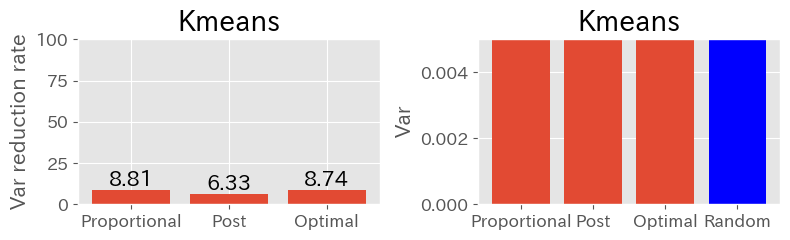

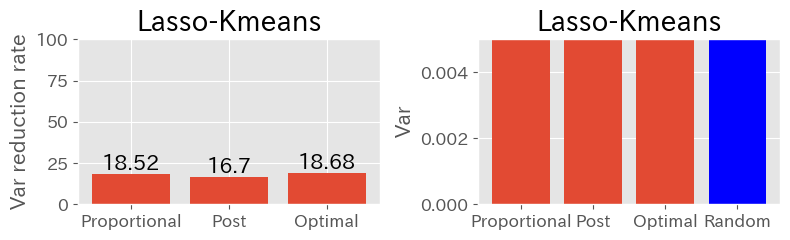

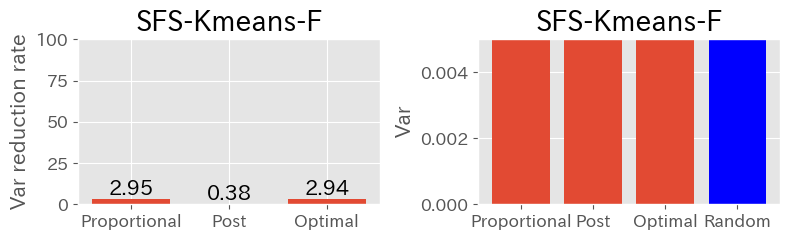

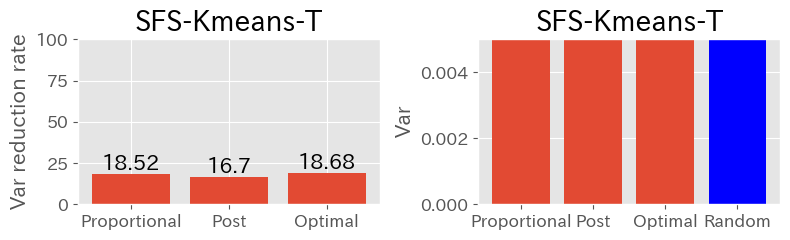

In [44]:
for _, method_name in METHODS_NAME_DICT.items():
    plot_bars(
        dicts=[
            REDUCTION_RATE_DICT_DICT_TRAIN[method_name],
            VAR_STRATIFIED_DICT_DICT_TRAIN[method_name],
        ],
        var_random=VAR_RANDOM_TRAIN,
        method_name=method_name,
        title_size=TITLE_SIZE,
        label_size=LABEL_SIZE,
        tick_size=TICK_SIZE,
    )

### テストデータの結果

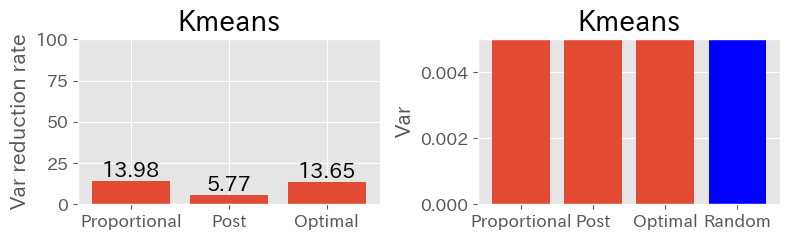

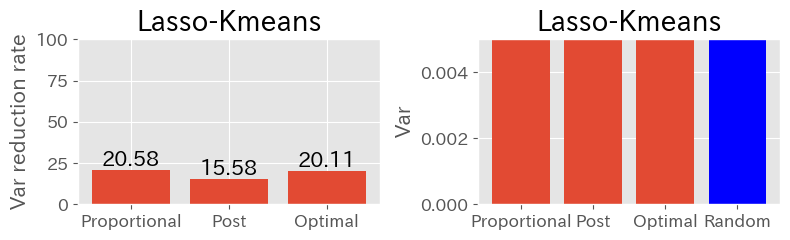

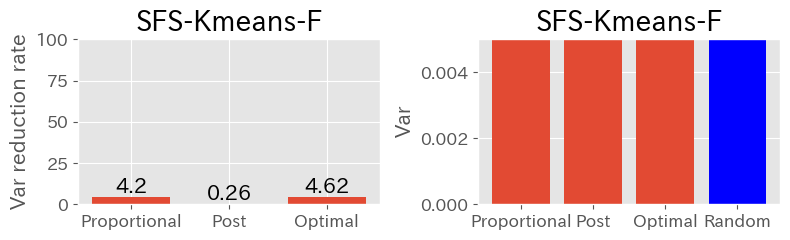

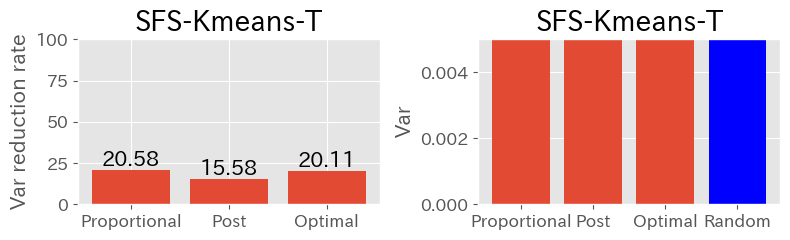

In [45]:
for _, method_name in METHODS_NAME_DICT.items():
    plot_bars(
        dicts=[
            REDUCTION_RATE_DICT_DICT_TEST[method_name],
            VAR_STRATIFIED_DICT_DICT_TEST[method_name],
        ],
        var_random=VAR_RANDOM_TEST,
        method_name=method_name,
        title_size=TITLE_SIZE,
        label_size=LABEL_SIZE,
        tick_size=TICK_SIZE,
    )

### 確認用

In [46]:
# 特徴量選択
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    print("選択された特徴量：", SELECTED_FEATURES_DICT[method_name])
    print(f"特徴量選択にかかった時間：{round(TIME_DICT[method_name], 3)} s")
    print()

【Kmeans】
選択された特徴量： [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
特徴量選択にかかった時間：0 s

【Lasso-Kmeans】
選択された特徴量： [ 0  4  8 12 16]
特徴量選択にかかった時間：1.705 s

【SFS-Kmeans-F】
選択された特徴量： [5 4 3 2 1]
特徴量選択にかかった時間：7.238 s

【SFS-Kmeans-T】
選択された特徴量： [ 4 12  8  0 16]
特徴量選択にかかった時間：7.199 s



In [47]:
# クラスタサイズ
print("【訓練データ】")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{CLUSTER_SIZE_DICT_TRAIN[method_name]}")

print()

print("【テストデータ】")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{CLUSTER_SIZE_DICT_TEST[method_name]}")

【訓練データ】
Kmeans:[17217 17238 16848 16007 16202 16488]
Lasso-Kmeans:[17094 16550 16673 16563 16455 16665]
SFS-Kmeans-F:[18137 17413 14945 15277 17132 17096]
SFS-Kmeans-T:[17094 16550 16673 16563 16455 16665]

【テストデータ】
Kmeans:[17157 17393 16790 15938 16292 16430]
Lasso-Kmeans:[17132 16606 16823 16486 16218 16735]
SFS-Kmeans-F:[18027 17493 14977 15379 17248 16876]
SFS-Kmeans-T:[17132 16606 16823 16486 16218 16735]


In [48]:
print("var_random_train =", VAR_RANDOM_TRAIN)
print("var_random_test =", VAR_RANDOM_TEST)

var_random_train = 0.10144553835868086
var_random_test = 0.10336472606427108


In [49]:
print("var_sep_dict_train =", VAR_STRATIFIED_DICT_DICT_TRAIN)
print("var_sep_dict_test =", VAR_STRATIFIED_DICT_DICT_TEST)

var_sep_dict_train = {'Kmeans': {'Proportional': 0.09251007173763133, 'Post': 0.09502751113443665, 'Optimal': 0.09258162400952653}, 'Lasso-Kmeans': {'Proportional': 0.08265733798502421, 'Post': 0.0845078297244742, 'Optimal': 0.08249206248847452}, 'SFS-Kmeans-F': {'Proportional': 0.09845165261835839, 'Post': 0.10106134117319535, 'Optimal': 0.09846344201349708}, 'SFS-Kmeans-T': {'Proportional': 0.08265733798502421, 'Post': 0.0845078297244742, 'Optimal': 0.08249206248847452}}
var_sep_dict_test = {'Kmeans': {'Proportional': 0.08891339308365402, 'Post': 0.0974045714438222, 'Optimal': 0.08925039334852822}, 'Lasso-Kmeans': {'Proportional': 0.08208754399245786, 'Post': 0.08726446533319498, 'Optimal': 0.08258180365763276}, 'SFS-Kmeans-F': {'Proportional': 0.0990257771374493, 'Post': 0.10309757948238543, 'Optimal': 0.09859251442593532}, 'SFS-Kmeans-T': {'Proportional': 0.08208754399245786, 'Post': 0.08726446533319498, 'Optimal': 0.08258180365763276}}
